In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("..")

In [52]:
from src.vols.heston import Heston
from src.losses.rbfmmdloss import RBFMMDLoss
from src.networks.rnn import RNNNetwork
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
set_plot_params()

In [155]:
N_paths = 100000
total_timesteps = 60*60*7.5 #1 second data
n_timesteps = 10 #train at 1 min interval

heston_model = Heston(theta=1.0, omega=0.04, xi=1.0, rho=0.0)
spots, vols = heston_model.generate(N_paths, total_timesteps, n_timesteps, reshape_for_rnn=True)

First train a model using a method of moments. We try to match the first $k$ moments of the distribution generated by 
$$
Z_F = \frac{X_1 - X_0}{\sqrt{F(X_0,X_{1/n},X_{2/n},\ldots,X_{(n-1)/n},X_1)}}
$$
to those of the standard normal. We set $k=4$ and train using the $L1$ norm. We use a simple feedforward neural network, and train for 10 epochs.

# Model 3: Using RBF MMD

In [157]:
rbfmmd_loss = RBFMMDLoss(length_scale=1.0)
rbfmmd_model = RNNNetwork(n_layers=4, h_dims=128, loss=rbfmmd_loss)

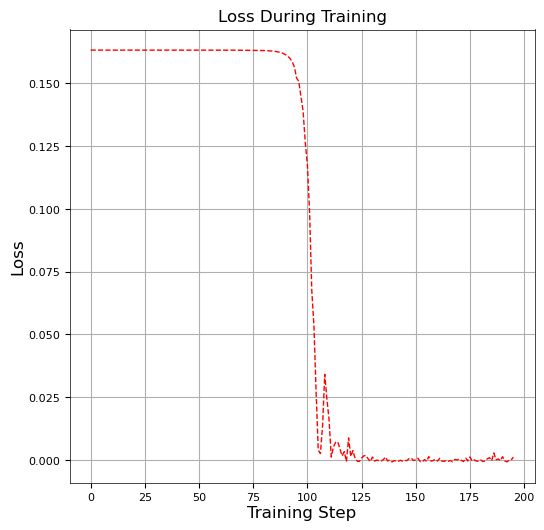

C:\Users\ebayuser\miniconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\ebayuser\miniconda3\lib\site-packages\tensorflow_core\python\keras\backend.py", line 4167, in <genexpr>
    ta.write(time, out) for ta, out in zip(output_ta_t, flat_output))  File "C:\Users\ebayuser\miniconda3\lib\site-packages\tensorflow_core\python\util\tf_should_use.py", line 237, in wrapped
    error_in_function=error_in_function)


C:\Users\ebayuser\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


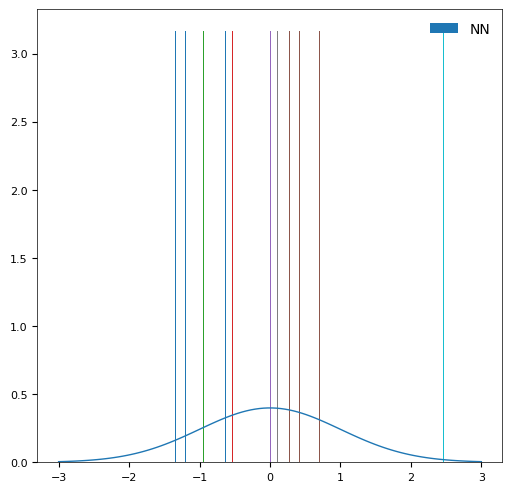

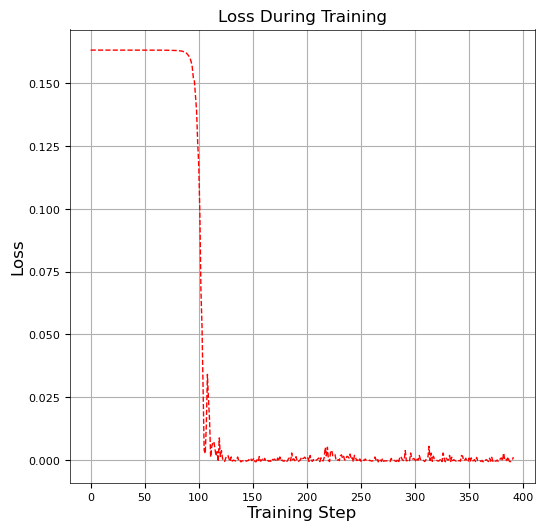

C:\Users\ebayuser\miniconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\ebayuser\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


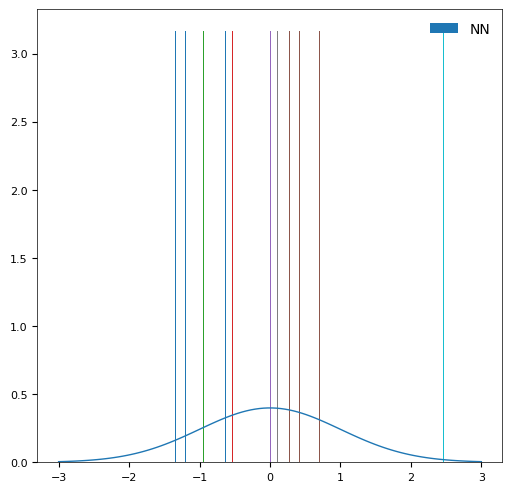

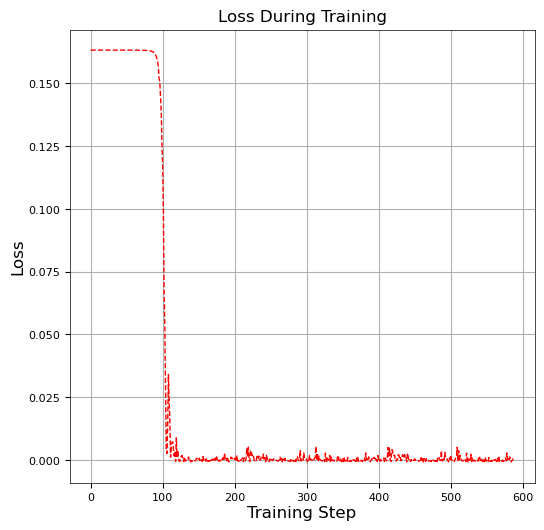

C:\Users\ebayuser\miniconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


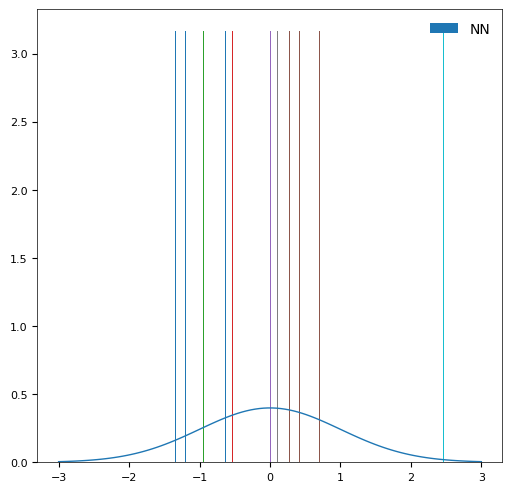

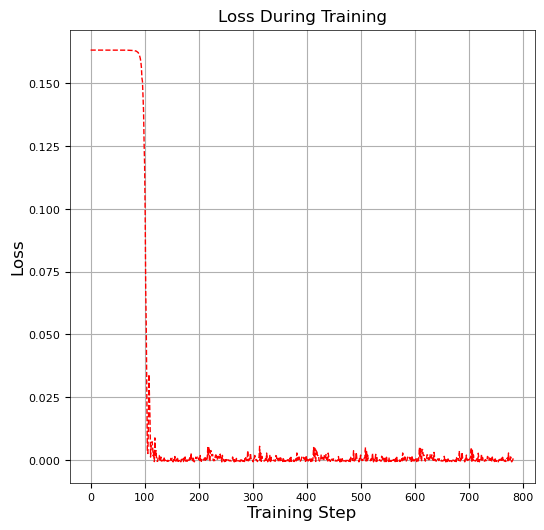

C:\Users\ebayuser\miniconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
C:\Users\ebayuser\miniconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


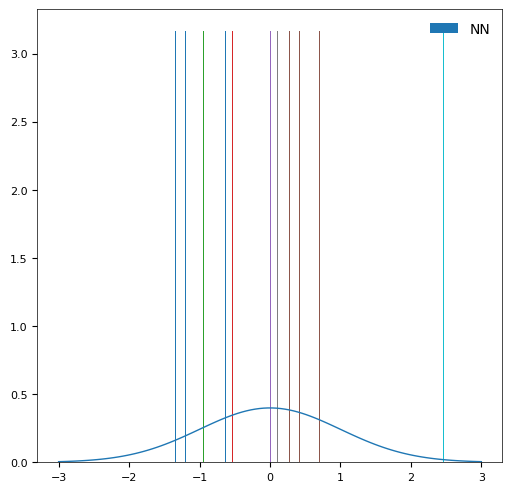

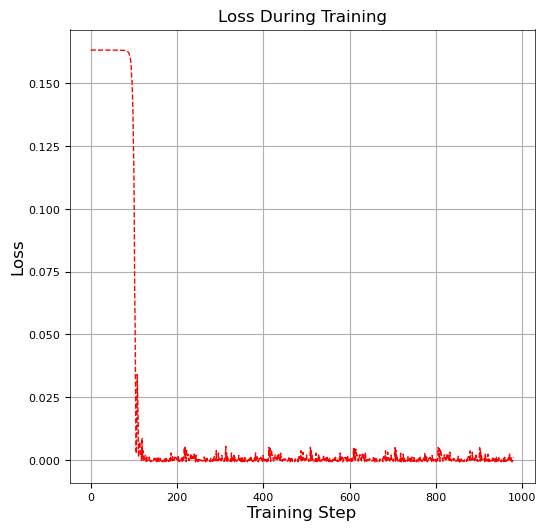

C:\Users\ebayuser\miniconda3\lib\site-packages\numpy\lib\histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


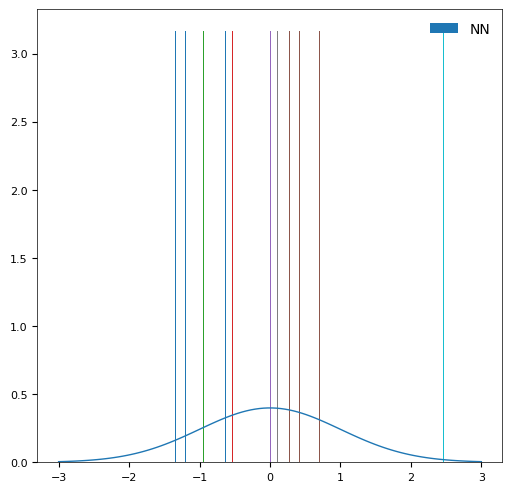

In [158]:
history = rbfmmd_model.train(spots, num_epochs=5, batch_size=512, lr=0.0001)

In [167]:
spots, vols = heston_model.generate(10000, total_timesteps, n_timesteps, reshape_for_rnn=True)
iv = rbfmmd_model.predict_iv(spots)

(array([  13.,  168.,  801., 2151., 2998., 2345., 1134.,  326.,   60.,
           4.]),
 array([0.86302915, 0.88202239, 0.90101563, 0.92000887, 0.93900211,
        0.95799535, 0.9769886 , 0.99598184, 1.01497508, 1.03396832,
        1.05296156]),
 <a list of 10 Patch objects>)

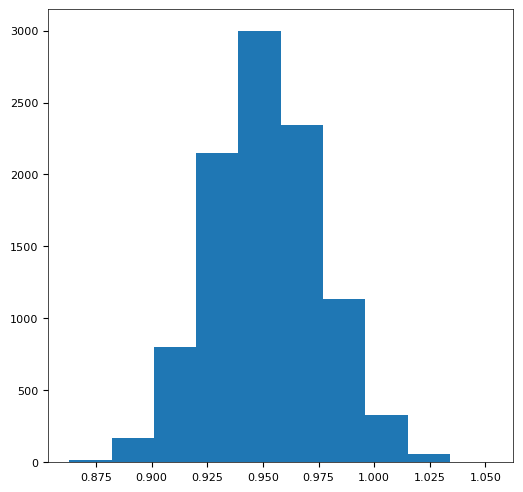

In [180]:
plt.hist(np.sqrt(iv) / np.sqrt(np.squeeze(true_ivs)))

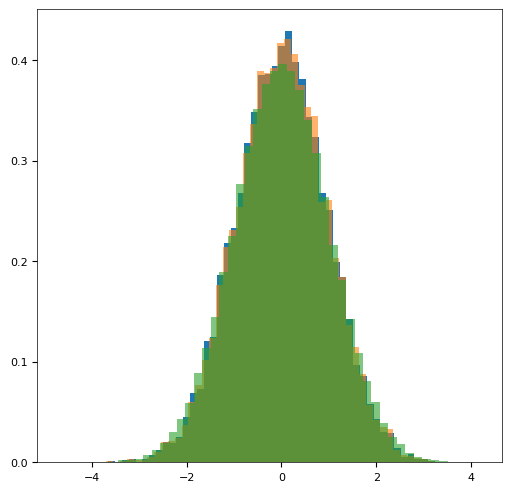

In [187]:
#plt.hist((spots[:,-1,0] - spots[:,0,0])/np.sqrt(iv), bins=50, density=True)
plt.hist((spots[:,-1,0] - spots[:,0,0])/np.sqrt(np.squeeze(true_ivs)), bins=50, density=True)
plt.hist((spots[:,-1,0] - spots[:,0,0])/np.sqrt(np.mean(true_ivs)), bins=50, alpha=0.6, density=True)


plt.hist(np.random.normal(size=100000), bins=50, alpha=0.6, density=True)
plt.show()

In [188]:
z = (spots[:,-1,0] - spots[:,0,0])/np.sqrt(np.squeeze(true_ivs))

In [190]:
RBFMMDLoss()(spots[:,-1,0] - spots[:,0,0], np.squeeze(true_ivs))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0003705099211863683>

In [191]:
RBFMMDLoss()(spots[:,-1,0] - spots[:,0,0], iv)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.6726540690958913e-05>

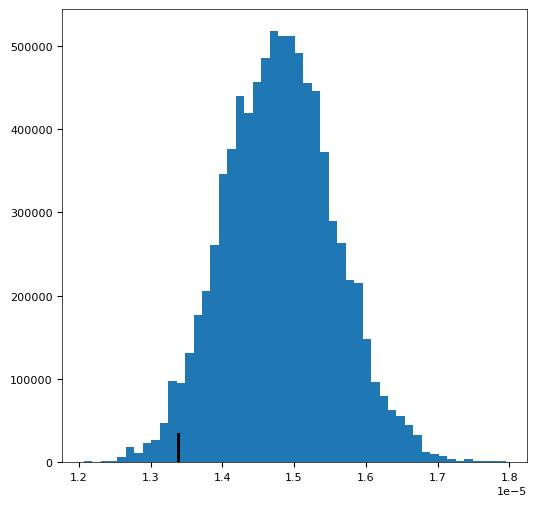

In [192]:
plt.hist(true_ivs, bins=50, density=True)
plt.vlines(iv, ymin=0, ymax=35000.0)
plt.show()

In [181]:
np.mean(true_ivs)

1.4802211489946724e-05